In [ ]:
# 1.2 Load Dependencies
!pip install tensorflow
import os
import librosa
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import kagglehub
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # CHANGED: Added for callbacks
from tensorflow.keras.regularizers import l2  # CHANGED: Added for regularization


In [ ]:
# Download dataset from KaggleHub
path = kagglehub.dataset_download("kenjee/z-by-hp-unlocked-challenge-3-signal-processing")
print("Path to dataset files:", path)

100%|██████████| 604M/604M [00:10<00:00, 60.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing/versions/1


In [ ]:
# 2.1 Define Paths to Files
CAPUCHIN_FILE = os.path.join(path, 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join(path, 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
# 2.2 Build Data Loading Function with Librosa
def load_wav_16k_mono(filename):
    # Load audio using Librosa (automatically resamples to 16kHz)
    waveform, _ = librosa.load(filename.numpy().decode(), sr=16000, mono=True)
    return tf.convert_to_tensor(waveform, dtype=tf.float32)

In [ ]:
# Wrap in tf.py_function for TensorFlow compatibility
def tf_load_wav_16k_mono(filename):
    return tf.py_function(load_wav_16k_mono, [filename], tf.float32)

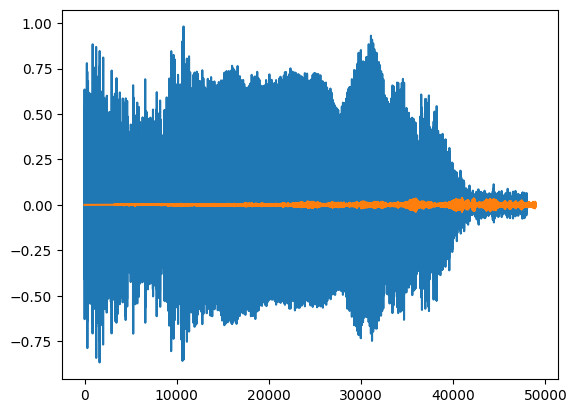

In [ ]:
# 2.3 Plot Wave
wave = tf_load_wav_16k_mono(tf.constant(CAPUCHIN_FILE))
nwave = tf_load_wav_16k_mono(tf.constant(NOT_CAPUCHIN_FILE))
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POS = os.path.join(path, 'Parsed_Capuchinbird_Clips')
NEG = os.path.join(path, 'Parsed_Not_Capuchinbird_Clips')

pos = tf.data.Dataset.list_files(os.path.join(POS, '*.wav'))
neg = tf.data.Dataset.list_files(os.path.join(NEG, '*.wav'))

# CHANGED: Calculate class weights for imbalance
pos_count = len(os.listdir(POS))
neg_count = len(os.listdir(NEG))
total = pos_count + neg_count
weight_for_0 = (1 / neg_count) * (total / 2.0)
weight_for_1 = (1 / pos_count) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class weights: {class_weight}")

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

Class weights: {0: 0.6829679595278246, 1: 1.8663594470046083}


In [ ]:
# 4.1 Calculate Wave Cycle Length
lengths = []
for file in os.listdir(os.path.join(path, 'Parsed_Capuchinbird_Clips')):
    tensor_wave = tf_load_wav_16k_mono(tf.constant(os.path.join(path, 'Parsed_Capuchinbird_Clips', file)))
    lengths.append(len(tensor_wave))

# 4.2 Calculate Mean, Min, and Max
print("Mean length:", tf.math.reduce_mean(lengths).numpy())
print("Min length:", tf.math.reduce_min(lengths).numpy())
print("Max length:", tf.math.reduce_max(lengths).numpy())

Mean length: 54156
Min length: 32000
Max length: 80000


Spectrogram shape: (1491, 257, 1)


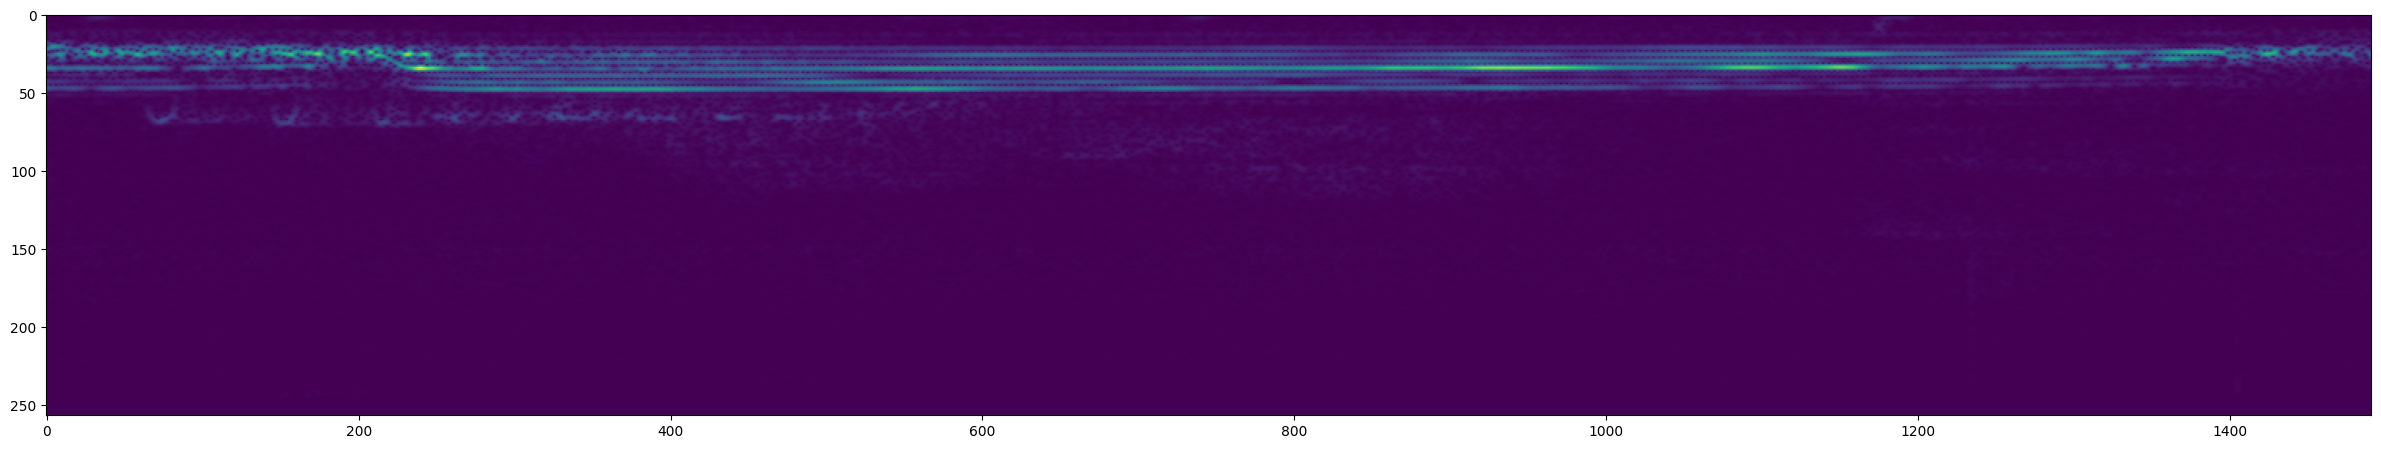

In [ ]:
# 5.1 Build Preprocessing Function
def preprocess(file_path, label):
    wav = tf_load_wav_16k_mono(file_path)
    wav = wav[:48000]  # Truncate or pad to 48000 samples
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)

    # Ensure consistent shape for the STFT output
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    # Add padding or slicing to ensure consistent shape
    spectrogram = tf.image.resize_with_crop_or_pad(spectrogram, 1491, 257)

    print("Spectrogram shape:", spectrogram.shape)  # Debug statement
    return spectrogram, label

# 5.2 Test Out the Function and Visualize the Spectrogram
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
# 6.1 Create a Tensorflow Data Pipeline
data = data.map(preprocess)
# CHANGED: Increased shuffle buffer and batch size
data = data.shuffle(buffer_size=1000)

# 1. Verify and split dataset
total_samples = len(list(data))
print(f"Total samples before batching: {total_samples}")

data = data.batch(32)
data = data.prefetch(tf.data.AUTOTUNE)
total_batches = len(list(data))
print(f"Total batches available: {total_batches}")

# Dynamic 80-20 split
split_idx = int(0.8 * total_batches)
train = data.take(split_idx)
test = data.skip(split_idx)

# Verify splits
print(f"Training batches: {len(list(train))}")
print(f"Test batches: {len(list(test))}")

# Fallback if test set empty
if len(list(test)) == 0:
    print("Using last 20% of train as test")
    test = train.take(max(1, int(0.2 * len(list(train)))))  # Ensure at least 1 batch
    train = train.skip(len(list(test)))

# 6.3 Test One Batch
samples, labels = train.as_numpy_iterator().next()
print("Batch shape:", samples.shape)  # Debug statement

Spectrogram shape: (1491, 257, None)
Total samples before batching: 810
Total batches available: 26
Training batches: 20
Test batches: 6
Batch shape: (32, 1491, 257, 1)


In [ ]:
# 7.1 Load Tensorflow Dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalMaxPooling2D
from tensorflow.keras.metrics import Recall, Precision

# 7.2 Build Sequential Model, Compile, and View Summary
# CHANGED: Added regularization and dropout
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                          input_shape=(1491,257,1),
                          kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu',
                          kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(128, activation='relu',
                        kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# CHANGED: Added gradient clipping and callbacks
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    clipnorm=1.0  # Gradient clipping
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1489, 255, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1489, 255, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1487, 253, 16)  │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1487, 253, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,785 (18.69 KB)

 Trainable params: 4,785 (18.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Debug the data pipeline
for spectrogram, label in train.take(1):
    print("Spectrogram shape:", spectrogram.shape)
    print("Label:", label)

Spectrogram shape: (32, 1491, 257, 1)
Label: tf.Tensor(
[1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0.], shape=(32,), dtype=float32)


Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 532s 26s/step - accuracy: 0.5211 - loss: 0.9527 - precision: 0.3504 - recall: 0.6399 - val_accuracy: 0.7471 - val_loss: 0.6358 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 559s 26s/step - accuracy: 0.6217 - loss: 0.8042 - precision: 0.3567 - recall: 0.3613 - val_accuracy: 0.7000 - val_loss: 0.6299 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 559s 26s/step - accuracy: 0.7270 - loss: 0.6733 - precision: 0.4713 - recall: 0.4878 - val_accuracy: 0.7000 - val_loss: 0.6408 - val_precision: 1.0000 - val_recall: 0.0377 - learning_rate: 0.0010
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 564s 26s/step - accuracy: 0.7148 - loss: 0.6373 - precision: 0.5222 - recall: 0.8378 - val_accuracy: 0.7000 - val_loss: 0.6179 - val_precision: 1.0000 - val_recall: 0.0377 - learning_rate: 0.0010
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 552s 

<Figure size 1500x500 with 0 Axes>

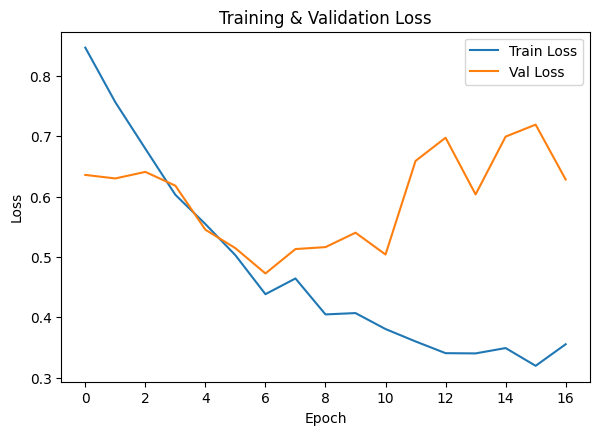

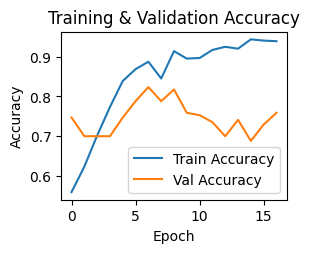

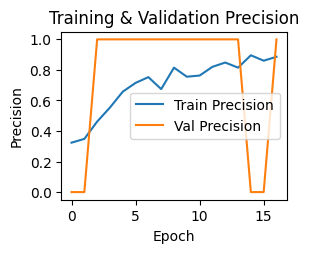

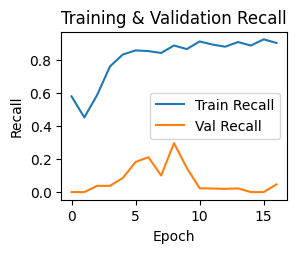

In [ ]:
# 7.3 Fit Model, View Loss and KPI Plots
# ==============================================
# 7. Training (FIXED VERSION)
# ==============================================
# CHANGED: 1. Made sure validation_data is properly formatted
#          2. Used consistent variable name 'history' (not 'hist')
history = model.fit(
    train,
    epochs=150,
    validation_data=test,  # Ensure this is batched the same way as train
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr],
    verbose=1  # Added to see progress
)

# ==============================================
# 8. Evaluation (FIXED PLOTTING)
# ==============================================
# CHANGED: 1. Verify keys exist before plotting
#          2. Use consistent variable name 'history'
print("Available keys:", history.history.keys())

plt.figure(figsize=(15,5))

plt.figure(figsize=(15,10))

# 1. Plot Loss
# if 'loss' in history.history and 'val_loss' in history.history:
plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 2. Plot Accuracy (NEW ADDITION)
# if 'accuracy' in history.history and 'val_accuracy' in history.history:
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 3. Plot Precision
# if 'precision' in history.history and 'val_precision' in history.history:
plt.subplot(2,2,3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Training & Validation Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 4. Plot Recall
# if 'recall' in history.history and 'val_recall' in history.history:
plt.subplot(2,2,4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Training & Validation Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
# ==============================================
# 8.1 Get One Batch and Make a Prediction (FIXED)
# ==============================================
try:
    # Get an iterator and safely get one batch
    test_iterator = test.as_numpy_iterator()
    X_test, y_test = next(test_iterator)

    # Make predictions
    yhat = model.predict(X_test)
    yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

    print("Predictions:", yhat[:10])  # Show first 10 predictions
    print("True labels:", y_test[:10])  # Show first 10 true labels

except StopIteration:
    print("Error: Test dataset is empty or already fully consumed")
    print("Debug info:")
    print(f"- Number of test batches: {len(list(test.as_numpy_iterator()))}")
    print(f"- Batch size: {test.element_spec[0].shape[0]}")

    # Recreate test set if needed
    test = data.skip(36).take(15).batch(32)
    print("\nRecreated test set with", len(list(test)), "batches")

    # Try again with new iterator
    try:
        X_test, y_test = next(test.as_numpy_iterator())
        yhat = model.predict(X_test)
        print("\nSuccessful prediction after reset:")
        print("Batch shape:", X_test.shape)
    except Exception as e:
        print("Final error:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions: [0, 0, 0, 1, 0, 0, 1, 0, 0, 1]
True labels: [0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]


In [ ]:
# 8.2 Convert Logits to Classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
# Import dependencies
import os
import tensorflow as tf
import librosa
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("kenjee/z-by-hp-unlocked-challenge-3-signal-processing")
print("Dataset downloaded to:", path)

# Verify the dataset structure
for root, dirs, files in os.walk(path):
    print("Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)
    print()

# 9.1 Load up MP3s
def load_mp3_16k_mono(filename):
    """ Load an MP3 file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    # Load audio with Librosa (automatically resamples to 16kHz)
    waveform, _ = librosa.load(filename, sr=16000, mono=True)
    return tf.convert_to_tensor(waveform, dtype=tf.float32)

# Load an MP3 file
mp3_file = os.path.join(path, 'Forest Recordings', 'recording_01.mp3')  # Use an existing file
if os.path.exists(mp3_file):
    wav = load_mp3_16k_mono(mp3_file)
    print("MP3 file loaded successfully.")
else:
    print("MP3 file not found:", mp3_file)

# Create audio slices
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()

Dataset downloaded to: /kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing
Directory: /kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing
Subdirectories: ['Parsed_Not_Capuchinbird_Clips', 'Forest Recordings', 'Parsed_Capuchinbird_Clips']
Files: []

Directory: /kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips
Subdirectories: []
Files: ['curlew-sound-3.wav', 'cricket-sounds-for-sleep-48.wav', 'sparrow-sound-effect-39.wav', 'crow-cawing-sound-effect-9.wav', 'cricket-sounds-for-sleep-5.wav', 'rain-thunder-and-crickets-sound-effect-4.wav', 'crickets-chirping-crickets-sound-0.wav', 'cricket-sounds-for-sleep-29.wav', 'afternoon-birds-song-in-forest-25.wav', 'birds-singing-in-forest-sounds-27.wav', 'rain-thunder-and-crickets-sound-effect-38.wav', 'sparrow-sound-effect-26.wav', 'rain-thunder-and-crickets-sound-effect-15.wav', 'crickets-chirping-crickets-sound-25.wav', 'crickets-sound-effect-1.wav', 'sparrow-sound-effect-40.wav', 'cricke

In [ ]:
# 9.2 Build Function to Convert Clips into Windowed Spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
# 9.3 Convert Longer Clips into Windows and Make Predictions
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]


3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step


In [ ]:
# 9.4 Group Consecutive Detections
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
print("Total calls detected:", calls)


Total calls detected: 0


In [ ]:
# 10.1 Loop Over All Recordings and Make Predictions
results = {}
for file in os.listdir(os.path.join(path, 'Forest Recordings')):
    FILEPATH = os.path.join(path, 'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

In [ ]:
# 10.2 Convert Predictions into Classes
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
# Print class_preds for debugging
print("class_preds:", class_preds)

class_preds: {'recording_76.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'recording_62.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'recording_48.mp3': [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'recording_44.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'recording_45.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
# 10.3 Group Consecutive Detections
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()


In [ ]:
import pandas as pd
# Convert to DataFrame
df = pd.DataFrame(list(postprocessed.items()), columns=['recording', 'capuchin_calls'])

# Display the DataFrame
display(df)

,recording,capuchin_calls
0,recording_76.mp3,0
1,recording_62.mp3,0
2,recording_48.mp3,4
3,recording_44.mp3,1
4,recording_45.mp3,3
...,...,...
95,recording_97.mp3,1
96,recording_50.mp3,0
97,recording_71.mp3,5
98,recording_34.mp3,4
